# import and dataloader

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import os
import torchvision
from modules import Generator, Discriminator

In [2]:
from data_loader import Data_Loader
dataloader = Data_Loader(dataset='celeb', image_path='./data', image_size=64, batch_size=64, shuf=True).loader()

# resume iters

In [3]:
def str2bool(v):
    return v.lower() in ('true')

config_ = {'imsize': 64,
           'z_dim': 128,
           'g_dim': 64,
           'd_dim': 64,
           'lambda_gp': 10,
           'version': 'sagan1',
           'total_step': 200000,
           'iter_start_decay': 100000,
           'lr_iter_decay': 1000,
           'resume_iter': None,
           'batch_size': 128,
           'g_lr': 0.0001,
           'd_lr': 0.0004,
           'lr_decay': 0.95,
           'beta1': 0.0,
           'beta2': 0.9,
           'dataset': 'celeb',
           'image_path': './data',
           'model_save_path': './models',
           'sample_path': './samples',
           'attn_path': './attn',
           'log_step': 20,
           'sample_step': 1000,
           'model_save_step': 4000}

In [4]:
class Configuration():
    def __init__(self):
        pass

config = Configuration()
for key, value in config_.items():
    setattr(config, key, value)

In [5]:
from trainer import Trainer

In [6]:
trainer = Trainer(data_loader=dataloader,config=config)


Generator(
  (attn2): SelfAttention(
    (query_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax()
  )
  (attn1): SelfAttention(
    (query_conv): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(64, 8, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax()
  )
  (main): Sequential(
    (0): SpectralNorm(
      (module): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1))
    )
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): SpectralNorm(
      (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Sp

In [7]:
trainer.restore_model(120000) # select which model to restore

Loading the trained models from step 120000...


# take out attn map and vizualize  
the purpose is to find attn map for certain pixel location; the attn map is over all locations

## viz image or feature maps

define a helper function that denorms tensor from (-1,1) to (0,1)

In [8]:
def denorm( x):
    out = (x + 1) / 2
    return out.clamp_(0, 1)

a helper func for viz

In [9]:
def viz(image, color=None):
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    samples = image
    height = samples.shape[1]
    width = samples.shape[2]

    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        
        if len(sample.shape) > 2:
            plt.imshow(sample.reshape(height, width, 3), cmap=color)
        else:
            plt.imshow(sample.reshape(height, width), cmap=color)

Total images in the batch: 64; size: [64, 3, 64, 64]


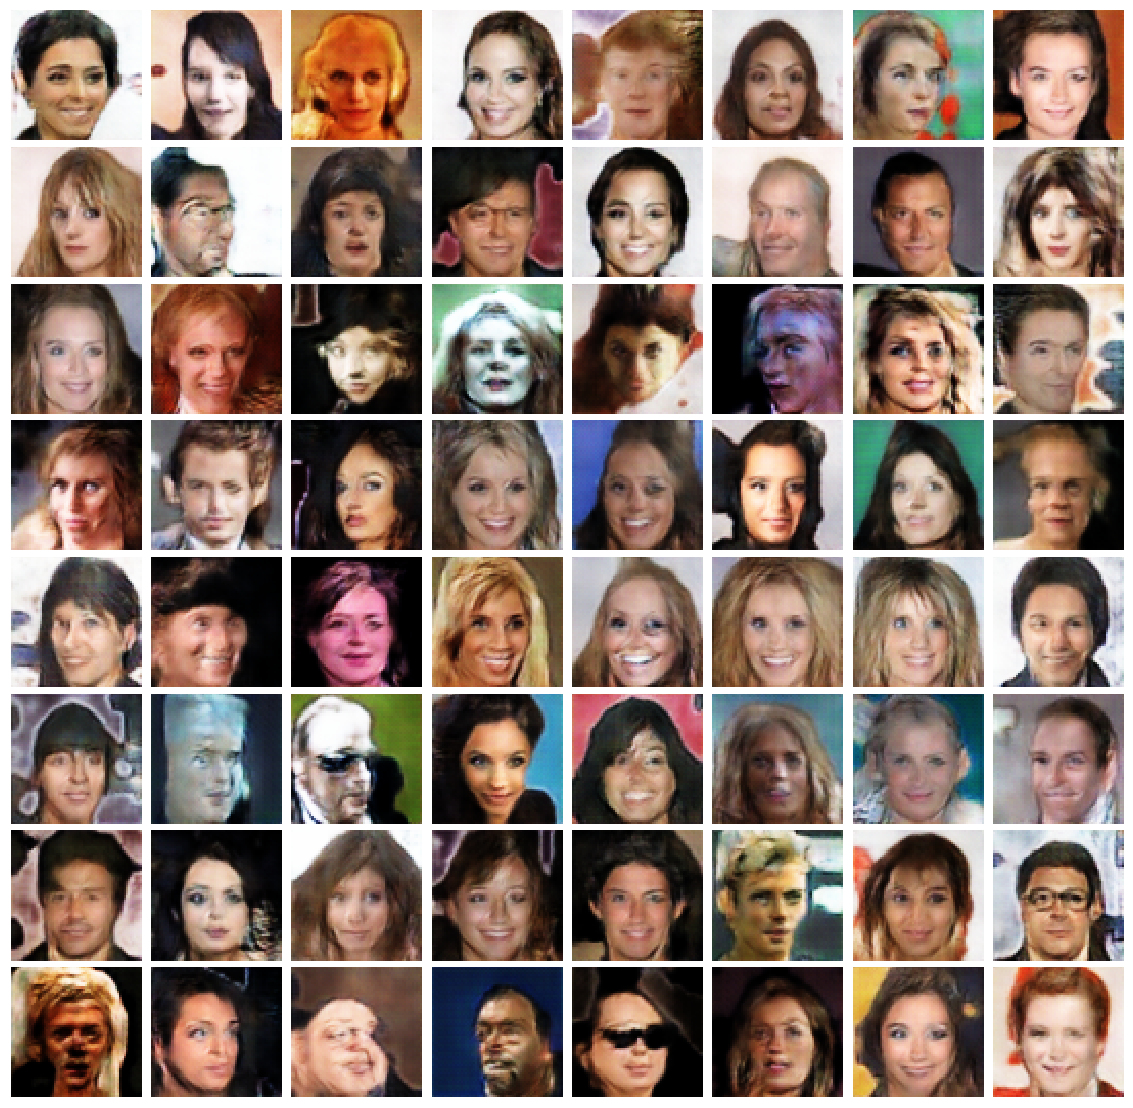

In [10]:
from signal import signal, SIGPIPE, SIG_DFL
signal(SIGPIPE,SIG_DFL) 
# to vizualize img
idx_in_batch = 0 # choose idx in the batch
batch_size = 64

z = torch.randn(batch_size, 128)
img_batch = trainer.G.cpu()(z) # forward z to get images of one batch; here one batch has 32 images
img_batch_T = img_batch.permute(0,2,3,1) # use permute instead of view to exchange channel, then good
print('Total images in the batch: {}; size: {}'.format(batch_size, list(img_batch.size())))

img_batch_np = denorm(img_batch_T).data.numpy() # denorm and turned to numpy array

viz(img_batch_np)

## viz feature maps

In [11]:
trainer.G.main[:-3]

Sequential(
  (0): SpectralNorm(
    (module): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1))
  )
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): SpectralNorm(
    (module): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): SpectralNorm(
    (module): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): SelfAttention(
    (query_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (key_conv): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
    (value_conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax()
  )
  (10): SpectralNorm(
    (module): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2

In [12]:
image_to_view = 3


z = z.view(z.size(0), z.size(1), 1, 1)
feature_maps = trainer.G.main[:-3].cpu()(z) # forward until the second last layer
map_np = feature_maps[image_to_view].data.numpy() # feature_maps for the image to view
print(map_np.shape) # this is feature map; every filter will produce one feature map when scanning over one image

(64, 32, 32)


for every image, there is one corresponding attn map which has the same size with that image, because for each pixel in that image, there are the same size of locations available to attent on.  


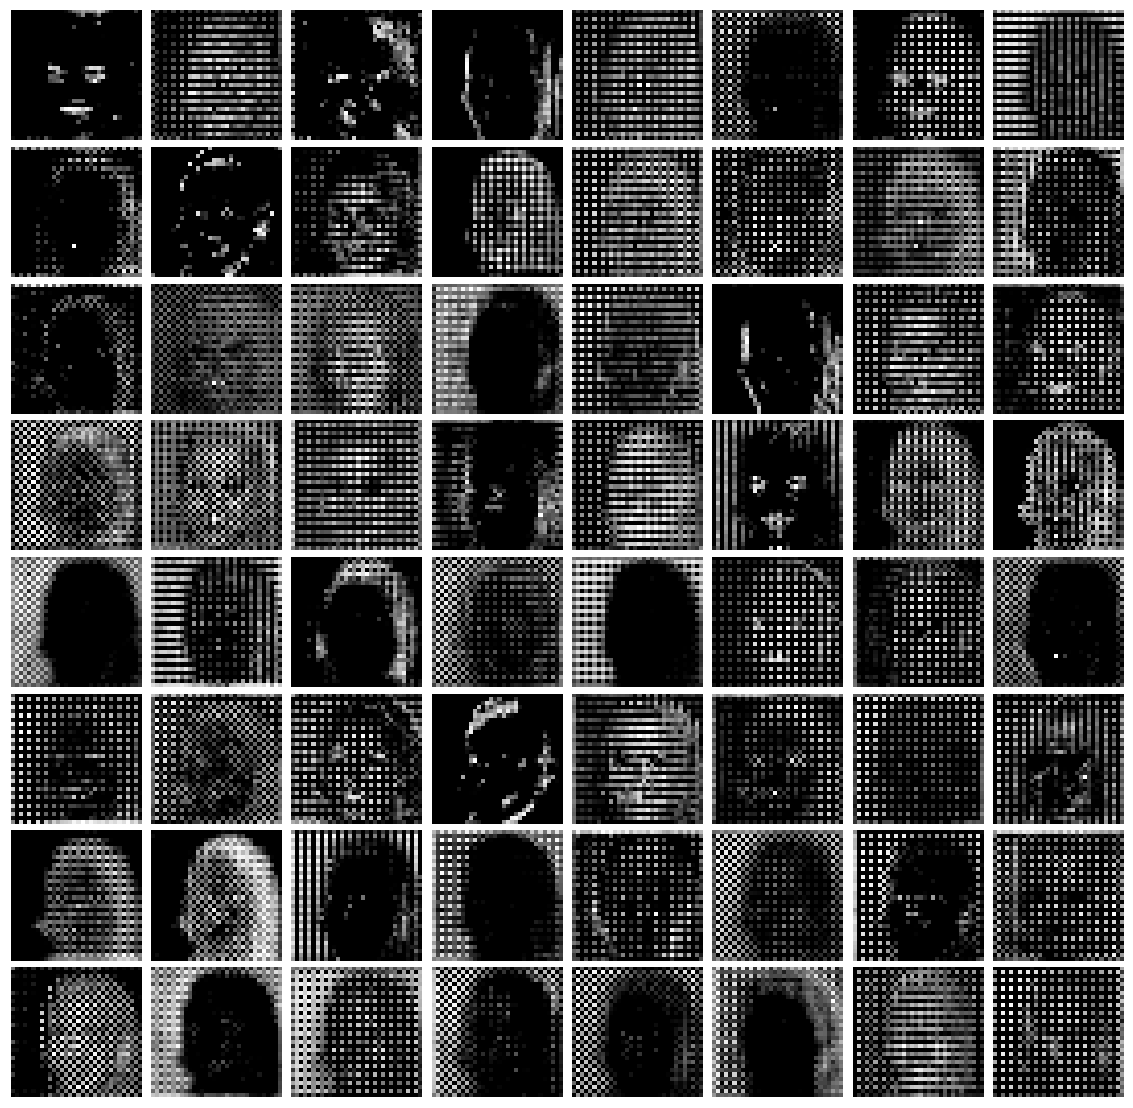

In [13]:
viz(map_np, color='Greys_r')

viz all feature maps for one image and find many dead filters, which causes many feature maps to be black so no much information was retained; could be solved by decreasing learning rate

## attn maps  
locate a pixel and find its attn map; attention was added before final layer, so attn map is over that layer

### locate_pixel function

525 is eye and 848 is teeth; 0 is black and 1 is white

In [32]:
# this function is used to locate pixel in terms of row and column
def locate_pixel(img, idx_attn_pixel):
    """
        args:
            img: single image
            idx_attn_pixel: i th pixel in image which has been flatten into one row(H x W); start from 1
        
        return: 
            columns and rows of pixel location in 2D map
    """
    row = idx_attn_pixel // img.shape[1]
    col = idx_attn_pixel % img.shape[1]
    assert idx_attn_pixel <= img.shape[1] * img.shape[0]
    if col == 0:
        row -= 1
        col += img.shape[1]
    return row, col-1

pixel_to_view = 848
col, row = locate_pixel(map_np[0], idx_attn_pixel=pixel_to_view)
print('the {}th pixel has x-y coordination: ({},{})'.format(pixel_to_view, col, row))

the 848th pixel has x-y coordination: (26,15)


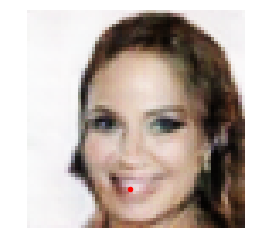

In [33]:
# usually double feature map 32x32 to 64x64 to get original resolution; so double row and col will match location in
# 64x64 output image
plt.imshow(img_batch_np[image_to_view]) # plot original image
plt.scatter(2*row, 2*col, s=20, c='red', marker='o')
plt.axis('off')
plt.show()

In [34]:
# check it with target location on feature map
# basically they are at the same location

(64, 32, 32)
attention on pixel: (26, 15)


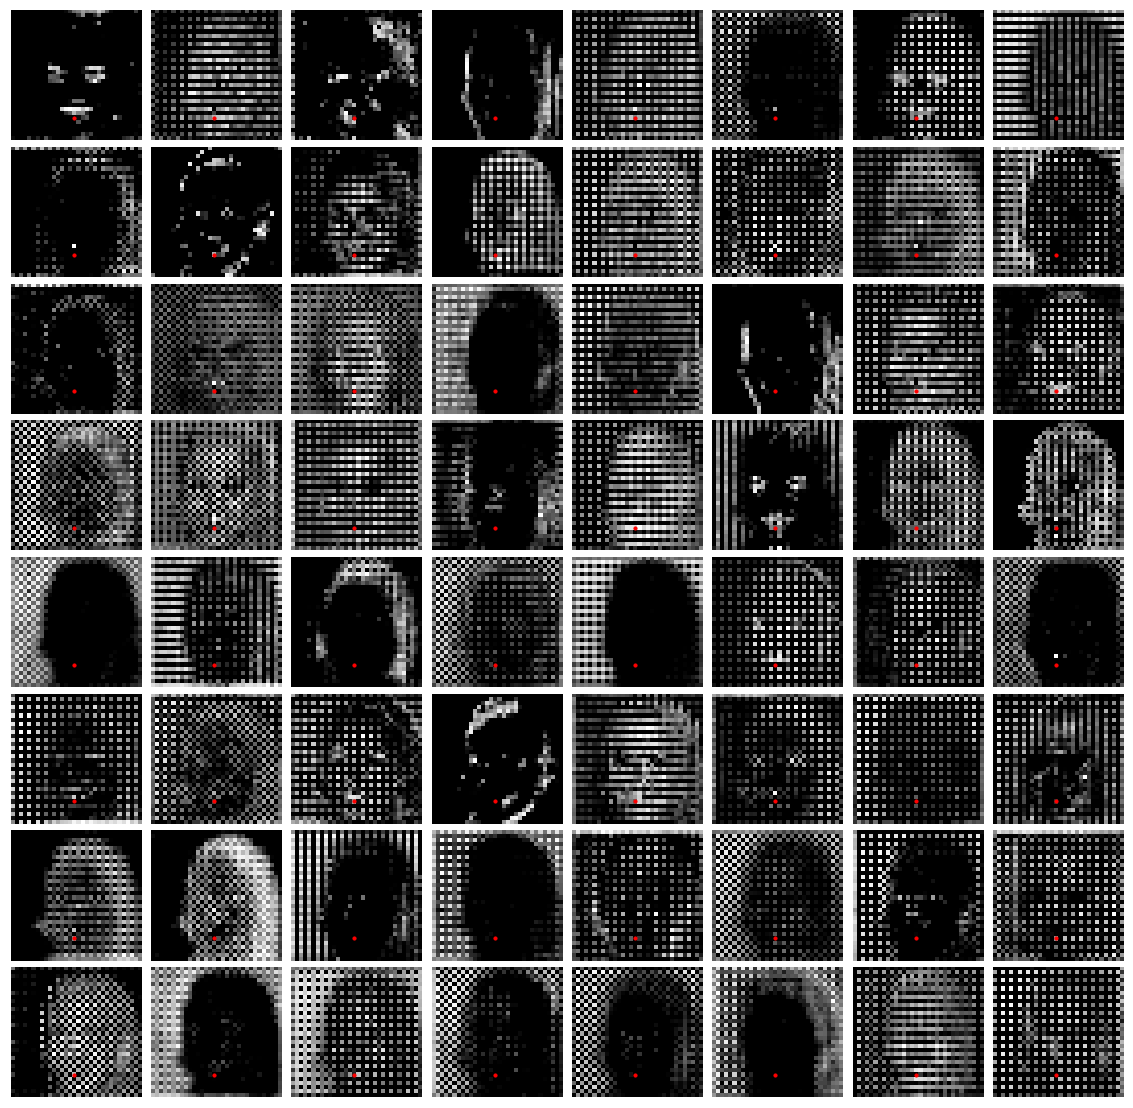

In [35]:
pixel_tar = pixel_to_view

z = z.view(z.size(0), z.size(1), 1, 1)
feature_maps = trainer.G.main[:-3].cpu()(z)

map_np = feature_maps[image_to_view].data.numpy()
print(map_np.shape)

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

samples = map_np

fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(8, 8)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(32, 32), cmap='Greys_r')
    row, col = locate_pixel(sample, pixel_tar)
    plt.scatter(col,row,s=10,c='red',marker='o')

print('attention on pixel: ({}, {})'.format(row, col))

Should show attn map directly on the feature map

In [36]:
trainer.G.watch_list2[0].size(), trainer.G.watch_list1[0].size() # 16 and 32 respectively

(torch.Size([64, 256, 256]), torch.Size([64, 1024, 1024]))

 * in order to generate the pixel on the right eye, the attn activates more on right side of face  
 * attn seems tend to focus on face outline instead of details

##  show attn map and feature map on different images and locations

attention on pixel: (26, 15)


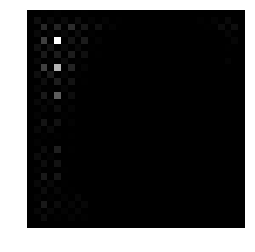

attn can be seen as a pdf over all locations； sum of attn: 1.000000238418579


In [37]:
pixel_tar = pixel_to_view

z = z.view(z.size(0), z.size(1), 1, 1)
feature_maps = trainer.G.main[:-3].cpu()(z)

map_np = feature_maps[image_to_view].data.numpy()

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

samples = map_np

row, col = locate_pixel(sample, pixel_tar)
print('attention on pixel: ({}, {})'.format(row, col))
attn = trainer.G.watch_list1[0] # list has only one attn

attn = attn[image_to_view][row * col].reshape(32,32).detach().cpu().data.numpy() # vizulaizer the 256th pixel attn on all locations
plt.imshow(attn, cmap='gray')
plt.axis('off')
plt.show()
print('attn can be seen as a pdf over all locations； sum of attn: {}'.format(np.sum(attn)))

ten largest idx: [645 263 131  71 259 261  69  67 389 133]
five largest idx: [131 259 389 261 133]
three largest idx: [389 261 133]
largest idx: 133
largest ten attn weights: [ 0.01608258  0.01889062  0.03400065  0.02419988  0.03411963  0.09567093
  0.02011963  0.02144927  0.04996428  0.13647117]
maximum weight on pixel: (4, 4)
maximum found by numpy: (array([4]), array([4]))


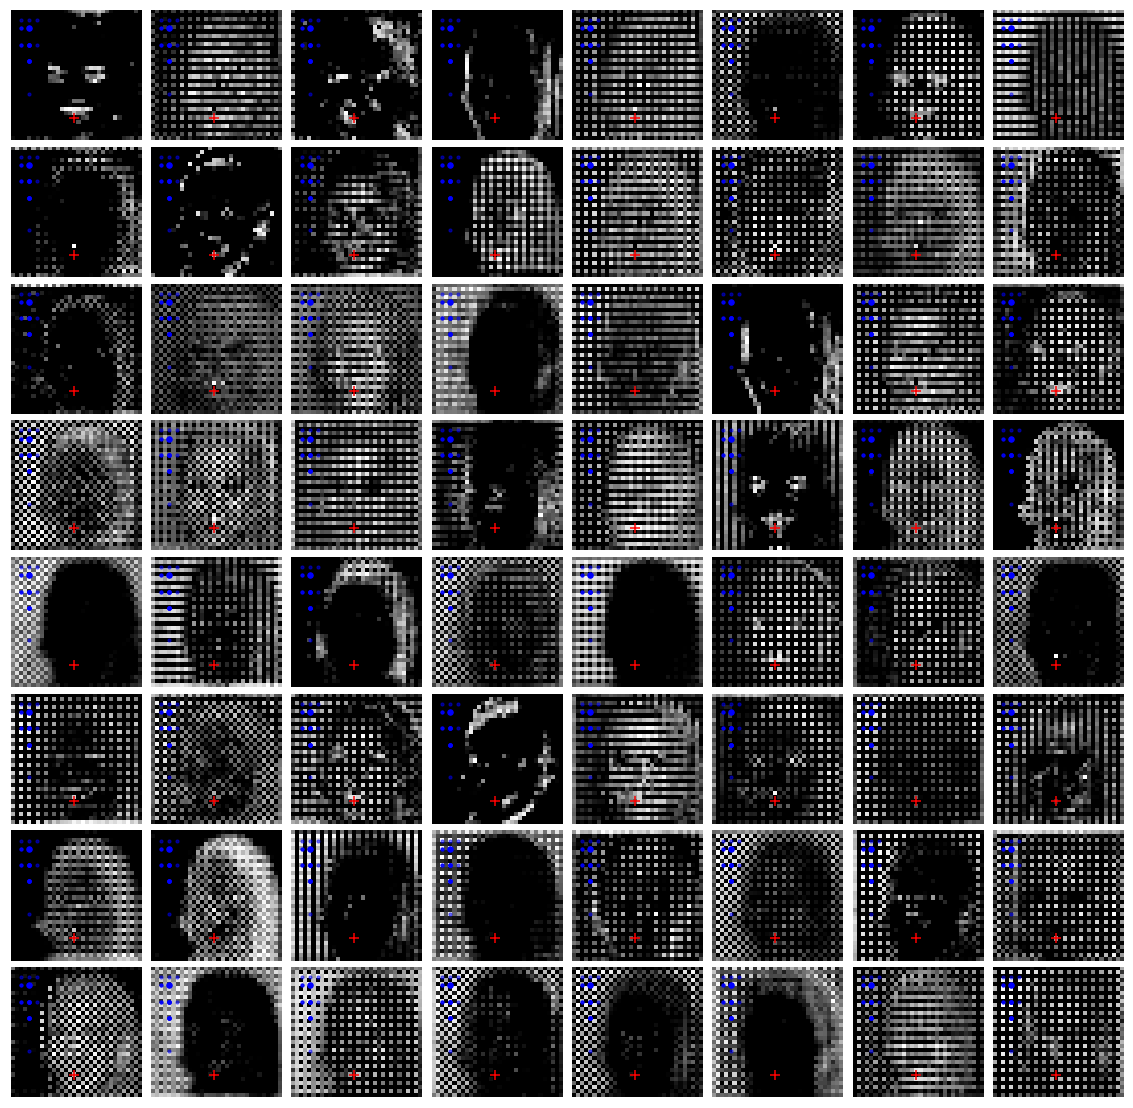

In [38]:
idxes_10 = np.argpartition(attn.reshape(-1), -10)[-10:] + 1
print('ten largest idx: {}'.format(idxes_10))
idxes_5 = np.argpartition(attn.reshape(-1), -5)[-5:] + 1
print('five largest idx: {}'.format(idxes_5))
idxes_3 = np.argpartition(attn.reshape(-1), -3)[-3:] + 1
print('three largest idx: {}'.format(idxes_3))
idx_argmax = attn.argmax() + 1 # should find 10 largest points
print('largest idx: {}'.format(idx_argmax))

print('largest ten attn weights: {}'.format(attn.reshape(-1)[idxes_10-1]))

def filter_median(idxes):
    global attn
    median = np.median(attn.reshape(-1)[idxes-1])
    idxes_ = [i for i in idxes if attn.reshape(-1)[i-1] >= 0.1 * median]
    return idxes_


assert len(filter_median(idxes_10)) == 10, 'there is top10 attn which has very small weight'

fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(8, 8)
gs.update(wspace=0.05, hspace=0.05)

for i, sample in enumerate(samples):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(32, 32), cmap='Greys_r')
    
    for i in idxes_10:
        row, col = locate_pixel(sample, i)
        plt.scatter(col,row,s=10,c='blue',marker='o',alpha=0.5)
        
    for i in idxes_5:
        row, col = locate_pixel(sample, i)
        plt.scatter(col,row,s=10,c='blue',marker='o',alpha=0.8)
        
    for i in idxes_3:
        row, col = locate_pixel(sample, i)
        plt.scatter(col,row,s=15,c='blue',marker='o')
        
    row_max, col_max = locate_pixel(sample, idx_argmax)
    plt.scatter(col,row,s=30,c='blue',marker='o')
        
    row, col = locate_pixel(sample, pixel_tar)
    plt.scatter(col,row,s=100,c='red',marker='+')
    

print('maximum weight on pixel: ({}, {})'.format(row_max, col_max))
print('maximum found by numpy: {}'.format(np.where(attn == attn.max())))
# find better way to mark attn points over feature map

Discriminator feature map is too blurr and can not extract useful visual information from those; discard